# Web scraping the Aggie

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.



In [1]:
import requests
import requests_ftp
import requests_cache
import lxml
import lxml.html as lx
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
plt.style.use('ggplot')
requests_cache.install_cache('coll_cache')
%matplotlib inline
from textblob import TextBlob
import re
import numpy as np
import nltk
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("brown")
nltk.download("wordnet")
nltk.download("stopwords")
import wordcloud

[nltk_data] Downloading package punkt to /Users/yilanliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yilanliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/yilanliu/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yilanliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yilanliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Function Explanation:

    Take a url from Aggie website and page number as input, output all links of articles.

In [2]:
def list_ariticle_url (url, page):
    url = url+'page/'+str(page)+'/'
    
    #download the web source information 
    response = requests.get(url)
    response.raise_for_status()
    doc = response.text
    
    #extract all links of articles
    html = lx.fromstring(doc, base_url = url)
    html.make_links_absolute()
    list_artical_url = html.xpath("//h2[@class = 'entry-title']/a/@href")
    
    return (list_artical_url)

##### test for list_ariticle_url function

In [3]:
list_ariticle_url ("https://theaggie.org/campus/", 1)

['https://theaggie.org/2018/03/06/duke-law-professor-presents-lecture-voting-rights-law/',
 'https://theaggie.org/2018/03/05/last-week-senate-25-8/',
 'https://theaggie.org/2018/03/05/icc-warns-students-wary-suspicious-job-offering/',
 'https://theaggie.org/2018/03/04/uc-davis-student-protester-arrested-yiannopoulos-talk-last-year-awaits-trial/',
 'https://theaggie.org/2018/03/01/executive-ticket-candidates-claim-biases-non-asucd-affiliated-individuals/',
 'https://theaggie.org/2018/03/01/happiness-campaign-strives-less-stress-joy/',
 'https://theaggie.org/2018/02/27/senator-term-review-yajaira-ramirez-sigala/',
 'https://theaggie.org/2018/02/27/calpirgs-winter-quarter-pledge-drives/',
 'https://theaggie.org/2018/02/26/asucd-election-results-announced-2/',
 'https://theaggie.org/2018/02/26/sexual-violence-prevention-response-board-created/',
 'https://theaggie.org/2018/02/26/memoriam-markos-huerta/',
 'https://theaggie.org/2018/02/25/traditional-chinese-music-classes-offered-uc-davis-c

#### Function Explanation:

        This function takes a url address as input, and output a dictionary that contains information for article.

In [4]:
def article(url):
    
    #download the web source information 
    response = requests.get(url)
    response.raise_for_status()
    doc = response.text
    
    #extract all links of articles
    html = lx.fromstring(doc, base_url = url)
    html.make_links_absolute()
    
    author = html.xpath("//a[@class = 'author-name author']/text()")
    title = html.xpath("//h1[@class = 'entry-title']/text()")
   
    try:
        text = html.xpath("//strong/text()")
    except:
        text = html.xpath("//div[@class = 'clearfix']/p//text()")
    
    text = text + html.xpath("//span[@style = 'font-weight: 400;']/text()")
    del text[-1]
    text = ' '.join(text)

    article = {}
    article["author"] = ' '.join(author)
    article["text"] = text
    article["title"] = ' '.join(title)
    article["url"] = url

    return (article)

#### test for article function

In [5]:
article("https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/")

{'author': 'Bianca Antunez  — city@theaggie.org',
 'text': 'Davis residents create financial model to make city’s financial state more transparent To increase transparency between the city’s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design.  Jeff Miller and Matt Williams, who are members of Davis’ Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager.  “City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city’s potential financial position over the long term,” Stachowicz said in an email interview. “We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with 

In [6]:
def article_summary (article_type, url, page_number):
    
    article_summary = pd.DataFrame(columns=["type","author","text","title","url"])

    for i in range(1, page_number+1):
        url_list = list_ariticle_url (url, i)
        for j in url_list:
            
            info_one = article(j)
            
            info = pd.DataFrame()
            info["author"] = [list(info_one.values())[0]]
            info["text"] = [list(info_one.values())[1]]
            info["title"] = [list (info_one.values())[2]]
            info["url"] = [list (info_one.values())[3]]
            info["type"]= [article_type]

            frames=[article_summary,info]
            article_summary = pd.concat(frames,ignore_index=True)
        
    return article_summary

In [7]:
campus_news = article_summary ("campus_news","https://theaggie.org/campus/", 4)
city_news = article_summary ("city_news","https://theaggie.org/city/", 4)

In [8]:
frames =  [campus_news, city_news]
result = pd.concat(frames,ignore_index=True )
result

,author,text,title,type,url
0,Jacqueline Moore — campus@theaggie.org,Guy-Uriel Charles speaks at King Hall Written ...,Duke law professor presents lecture on voting ...,campus_news,https://theaggie.org/2018/03/06/duke-law-profe...
1,Priyanka Shreedar — campus@theaggie.org,Controversial prosecution of UC Davis student ...,Last Week in Senate,campus_news,https://theaggie.org/2018/03/05/last-week-sena...
2,Clara Zhao — campus@theaggie.org,Scammers contact students posing as potential ...,ICC warns students to be wary of suspicious jo...,campus_news,https://theaggie.org/2018/03/05/icc-warns-stud...
3,Aaron Liss — campus@theaggie.org,Noah Benham faces four charges Written by: Aar...,UC Davis student protester arrested at Yiannop...,campus_news,https://theaggie.org/2018/03/04/uc-davis-stude...
4,Elizabeth Mercado — campus@theaggie.org,"ACT slate candidates, disqualified Golden Slat...",Executive ticket candidates claim biases again...,campus_news,https://theaggie.org/2018/03/01/executive-tick...
5,George Liao — campus@theaggie.org,The Happiness Campaign seeks to reduce anxiety...,"Happiness Campaign strives for less stress, mo...",campus_news,https://theaggie.org/2018/03/01/happiness-camp...
6,Sabrina Habchi — campus@theaggie.org,Ramirez Sigala’s performance as ASUCD senator ...,Senator Term Review: Yajaira Ramirez Sigala,campus_news,https://theaggie.org/2018/02/27/senator-term-r...
7,Clara Zhao — campus@theaggie.org,History behind CALPIRG Written by: Clara Zhao ...,CALPIRG’s Winter Quarter pledge drives,campus_news,https://theaggie.org/2018/02/27/calpirgs-winte...
8,Clara Zhao — campus@theaggie.org,"President Michael Gofman, Vice President Shani...",ASUCD election results announced,campus_news,https://theaggie.org/2018/02/26/asucd-election...
9,George Liao — campus@theaggie.org,Systemwide student advisory board formed to in...,Sexual Violence Prevention and Response Board ...,campus_news,https://theaggie.org/2018/02/26/sexual-violenc...


In [9]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string
stopwords = stopwords.words("english")

In [10]:
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

#### text_processor function explanation:

    take text as input
    output a list with all words without stopwords and non-alphabetic elements in text.

In [11]:
def text_processor(text):
    blob = TextBlob(text)
    new_text = " ".join(w for w in blob.words if w.lower() not in stopwords)
    blob = TextBlob(new_text)
    
    tags = [wordnet_pos(x[1]) for x in blob.pos_tags]
    new_text = " ".join(x.lemmatize(t) for x, t in zip(blob.words, tags))
    
    
    blob = TextBlob(new_text)
    word_list = list(blob.words)

    word_list_filter = [re.sub("[^ \w]"," ",x).strip().lower() for x in word_list]
    word_list_filter = list(filter(None, word_list_filter))
    
    return word_list_filter

In [12]:
#return the top 30 words frequent in a text 
def top_30_word(texts):
    
    #for each text, processe it then store in a large list
    text_list_all = []
    
    for text in texts:
        text_list_one = text_processor(text)
        text_list_all = text_list_all + text_list_one
        
    word = list(Counter(text_list_all).keys())
    freq = list(Counter(text_list_all).values())
    
    word_analysis_df = pd.DataFrame({"word":word, "freq":freq})
    word_analysis_df = word_analysis_df.sort_values(['freq'],ascending=False).head(n=30).set_index('word')

    return word_analysis_df

In [13]:
#plot bar plot based on a dataframe, which has the desired x lable as index, and desired y value as first column
def plot_df(df,ylable, xlable,title):
    df.plot.bar()
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.title(title)
    plt.show()
    

#### What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

In [14]:
titles =  result.iloc[:,2]
title_freq_df = top_30_word(titles)
title_freq_df.head()


,freq
word,
davis,26
police,14
sacramento,13
uc,12
new,11


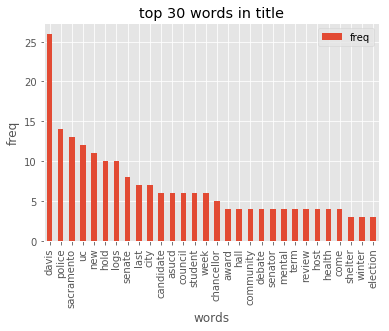

In [15]:
plot_df(title_freq_df,"freq","words","top 30 words in title")

    The top 30 words in title includs davis, sacramento, uc and city, 
    
    After ignoring words like new,hold, week, host, those ambigous words in top 30 words, 
    the most frequent mentioned word are in three categories:
    
    1. the most frequent among all are davis, sacramento, uc, students.
       since this is an ucdavis based website, those words represents the identity of the website. 
       
    2. the second most frequent words group are police logs, senate, candidate, asucd, council, debate, election, 
      those words represents activity of students, most of them are about anual student club election, and police logs
    
    3. the third most frequent words group are health, winter, shelter, award, community, mental
        those words represents the general topic of articles on aggie, the concerns from students and current hot topics, rather than elections and police logs. 

In [16]:
titles_city =  result[result["type"] =="city_news"].iloc[:,2]
titles_city_freq_df = top_30_word(titles_city)
titles_city_freq_df.head()

,freq
word,
davis,18
sacramento,12
police,12
logs,10
new,9


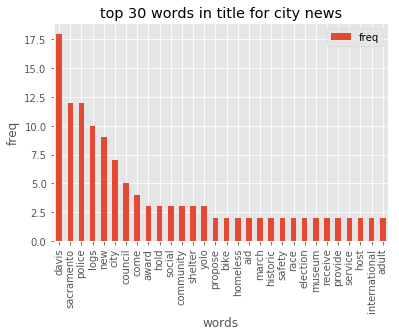

In [17]:
plot_df(titles_city_freq_df,"freq","words","top 30 words in title for city news")

    city news is has more words about the current life circumstances, safaty report, and news around yolo county (sacramento, davis, yolo).
    while as campus new is more about student's life and election activity among students in davis (davis, uc).

In [18]:
titles_campus =  result[result["type"] =="campus_news"].iloc[:,2]
titles_campus_freq_df = top_30_word(titles_campus)
titles_campus_freq_df.head()

,freq
word,
uc,11
davis,8
senate,8
hold,7
last,7


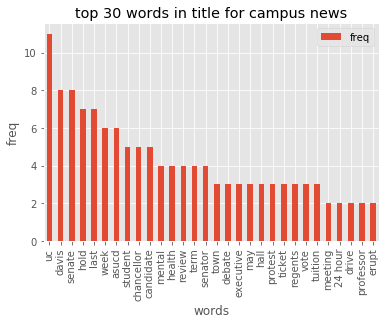

In [19]:
plot_df(titles_campus_freq_df,"freq","words","top 30 words in title for campus news")

#### What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

In [20]:
all_text = list(result.iloc[:,1])

# get the all text from croupus and clean it before analysis
all_text_clean = []
for i in range(0,len(all_text)):
    one_clean = text_processor(all_text[i])
    one_clean = ' '.join(one_clean)
    all_text_clean.append(one_clean) 
  

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer().fit_transform(all_text_clean)

# Use .A to display a sparse matrix.
cov = (tf_idf * tf_idf.T).A
cov_df = pd.DataFrame(cov)


In [22]:
#get the upper half of the covariance dataframe and stack them into a new 3 column dataframe
cov_df_1 = cov_df.where(np.triu(np.ones(cov_df.shape)).astype(np.bool))
cov_df_2 = cov_df_1.stack().reset_index()
cov_df_2.columns = ['row','column','cov']

#delete row=column value, since self comparison is not neccesary
cov_df_2 = cov_df_2[cov_df_2['row'] != cov_df_2['column']]
#delete all row with covarience value = 0
cov_df_2 = cov_df_2[cov_df_2['cov'] !=0]

cov_df_2 = cov_df_2.sort_values(['cov'],ascending=False)

cov_df_2.head()

,row,column,cov
1485,13,16,1.000000
1377,12,15,1.000000
1592,14,17,1.000000
489,4,19,0.674715
1617,14,42,0.562338


In [23]:
row_title = []
column_title = []
a,b = cov_df_2.shape
for i in range(0,a):
    row_title.append(result.iloc[cov_df_2.iloc[i][0].astype(np.int64)][2]) 
cov_df_2["row_title"] = row_title

for i in range(0,a):
    column_title.append(result.iloc[cov_df_2.iloc[i][1].astype(np.int64)][2]) 
cov_df_2["column_title"] = column_title

cov_df_2.head(n=10)

,row,column,cov,row_title,column_title
1485,13,16,1.000000,ASUCD executive tickets hold CoHo debate,ASUCD executive tickets hold CoHo debate
1377,12,15,1.000000,Last week in Senate,Last week in Senate
1592,14,17,1.000000,Mental Health Town Hall erupts in protest,Mental Health Town Hall erupts in protest
489,4,19,0.674715,Executive ticket candidates claim biases again...,Adam Hatefi and Shreya Deshpande disqualified ...
1617,14,42,0.562338,Mental Health Town Hall erupts in protest,Internal audit reveals steep decline in counse...
1929,17,42,0.562338,Mental Health Town Hall erupts in protest,Internal audit reveals steep decline in counse...
2013,18,24,0.528787,ASUCD Senate candidates debate to largely inat...,2018 ASUCD Winter Elections — meet the candidates
1808,16,24,0.524777,ASUCD executive tickets hold CoHo debate,2018 ASUCD Winter Elections — meet the candidates
1493,13,24,0.524777,ASUCD executive tickets hold CoHo debate,2018 ASUCD Winter Elections — meet the candidates
4987,53,58,0.515670,UC Regents postpone tuition hike vote until May,UC Regents to vote over proposed increase to s...


In [24]:
cov_df_3 = cov_df_2.groupby(["cov",'row_title', 'column_title']).size().reset_index(name='count')
cov_df_3 = cov_df_3.sort_values(['cov'],ascending=False)
cov_df_3.head(n=10)

,cov,row_title,column_title,count
6782,1.000000,ASUCD executive tickets hold CoHo debate,ASUCD executive tickets hold CoHo debate,1
6781,1.000000,Last week in Senate,Last week in Senate,1
6780,1.000000,Mental Health Town Hall erupts in protest,Mental Health Town Hall erupts in protest,1
6779,0.674715,Executive ticket candidates claim biases again...,Adam Hatefi and Shreya Deshpande disqualified ...,1
6778,0.562338,Mental Health Town Hall erupts in protest,Internal audit reveals steep decline in counse...,2
6777,0.528787,ASUCD Senate candidates debate to largely inat...,2018 ASUCD Winter Elections — meet the candidates,1
6776,0.524777,ASUCD executive tickets hold CoHo debate,2018 ASUCD Winter Elections — meet the candidates,2
6775,0.515670,UC Regents postpone tuition hike vote until May,UC Regents to vote over proposed increase to s...,1
6774,0.505118,New affordable housing and emergency service c...,Interfaith Rotating Winter Shelter to be held ...,1
6773,0.477644,Mental Health Town Hall erupts in protest,Director of Counseling and Psychological Servi...,2


In [25]:
cov_df_3.iloc[3][1],cov_df_3.iloc[3][2]

('Executive ticket candidates claim biases against non-ASUCD affiliated individuals',
 'Adam Hatefi and Shreya Deshpande disqualified after missing mandatory Candidate Workshop')

In [26]:
cov_df_3.iloc[4][1],cov_df_3.iloc[4][2]

('Mental Health Town Hall erupts in protest',
 'Internal audit reveals steep decline in counselors, $250,000 worth of questionably allocated funds')

In [27]:
cov_df_3.iloc[5][1],cov_df_3.iloc[5][2]

('ASUCD Senate candidates debate to largely inattentive crowd',
 '2018 ASUCD Winter Elections — meet the candidates')

#### Analysis:

    Notice that some covariance = 1, which means these to articles are exactly the same. By examine the above dataframw, for covariance = 1 pair of articles, they have same titles, thus we may conclude that same article has been published twice on aggie. 
    
    Thus when comparing similarities among articles, we ignore repeated published articles when they are comparing 
    to themselves. Then the resulting top 3 similar articles are:
    
    1. 'Executive ticket candidates claim biases against non-ASUCD affiliated individuals',
       'Adam Hatefi and Shreya Deshpande disqualified after missing mandatory Candidate Workshop'
    
    2. 'Mental Health Town Hall erupts in protest',
       'Internal audit reveals steep decline in counselors,$250,000 worth of questionably allocated funds
    
    3. 'ASUCD Senate candidates debate to largely inattentive crowd',
       '2018 ASUCD Winter Elections — meet the candidates'
       
    Next, we are going to analysis: What words do they have in common?
    
    The words in common are collected, and the repeated times are counted. 

In [28]:
#take 2 text and return a dataframe with the words in common as index, and repeated times as the first column
def word_in_common(text1, text2):
    text1 = text_processor(text1)
    text2 = text_processor(text2)
    
    common = {}
    for i in text1:
        common[i] = text2.count(i) 
        
    word = list(Counter(common).keys())
    freq = list(Counter(common).values())
    
    common_df = pd.DataFrame({"word":word, "freq":freq})
    common_df = common_df.sort_values(['freq'],ascending=False).set_index('word').head(n=30)
    return common_df

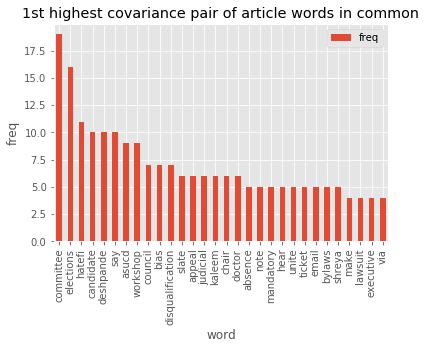

In [29]:
df_common_1st_pair = word_in_common(result.iloc[cov_df_2.iloc[3][0].astype(np.int64)][1],result.iloc[cov_df_2.iloc[3][1].astype(np.int64)][1])
plot_df(df_common_1st_pair,"freq", "word","1st highest covariance pair of article words in common")

#### Analysis:
       
       For the first pair:

    1. 'Executive ticket candidates claim biases against non-ASUCD affiliated individuals',
       'Adam Hatefi and Shreya Deshpande disqualified after missing mandatory Candidate Workshop'
       
       The top 30 words in common with the highest repeated numbers includs commitee, elections, hatefi, and candidate. This corresponds with the expectations, since the topic is about candidates election in UCD, and hatefi is one of the cadidate's name. 

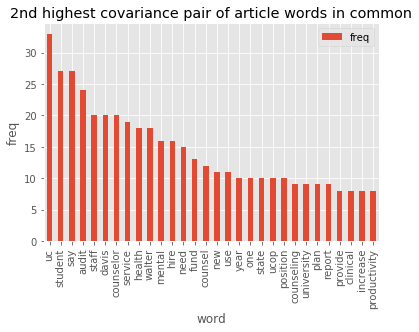

In [30]:
df_common_2nd_pair = word_in_common(result.iloc[cov_df_2.iloc[4][0].astype(np.int64)][1],result.iloc[cov_df_2.iloc[4][1].astype(np.int64)][1])
plot_df(df_common_2nd_pair,"freq", "word","2nd highest covariance pair of article words in common")

#### Analysis:
       
       For the second pair:

    2. 'Mental Health Town Hall erupts in protest',
       'Internal audit reveals steep decline in counselors,$250,000 worth of questionably allocated funds
       
       The top 30 words in common with the highest repeated numbers includes students, senate, community, which are ambiguous to analysis based on those words and title. Maybe the declination in counselors results in erupts in Mental Health Town Hall, but we might need futher analysis to draw conclusion

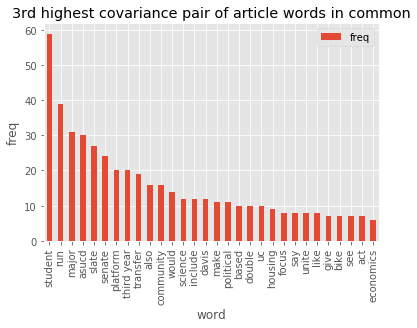

In [31]:
df_common_3rd_pair = word_in_common(result.iloc[cov_df_2.iloc[6][0].astype(np.int64)][1],result.iloc[cov_df_2.iloc[6][1].astype(np.int64)][1])
plot_df(df_common_3rd_pair,"freq", "word","3rd highest covariance pair of article words in common")

#### Analysis:
       
       For the third pair:

    3. 'ASUCD Senate candidates debate to largely inattentive crowd',
       '2018 ASUCD Winter Elections — meet the candidates'       
       
       The top 30 words in common with the highest repeated numbers includes students, run, asucd, community. Again, based on the titles, we can say, like the first pair, they are articles about elections. Thus it's resonable for us to observe those words in common

#### Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

In [32]:
#get all text in corpus, and get the top 30 frequent words in all text.
texts =  result.iloc[:,1]
texts_freq_df = top_30_word(texts)
texts_freq_df.head()

,freq
word,
student,768
say,737
davis,552
uc,374
community,243


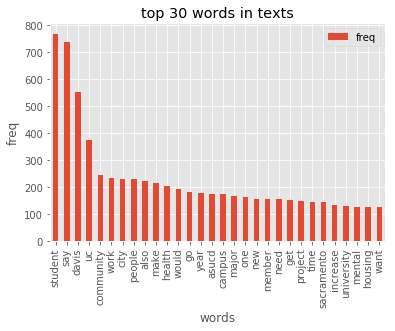

In [33]:
plot_df(texts_freq_df,"freq","words","top 30 words in texts")


#### Analysis:
       
       Notice in the top 30 words in texts, students, ucdavis, uc, university, and housing are included. This represents the current life concern for ucdavis students. Thus the corpus is representitive of Aggie. Based on the corpus, health, mental, housing and major are in top 30 words, thus those might be the topic that uc davis student concerned and interested about. 